In [ ]:
# Dataset 압축 해제
#!mkdir -p /content/OX_Dataset
!unzip -qq /content/Dataset.zip -d /content/OX_Dataset

In [ ]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

import torch.nn.functional as F

import matplotlib.pyplot as plt



이미지 변환해서 데이터 증가시키는 코드

In [ ]:
import random
import numpy as np
import os
import cv2
from PIL import Image

def img_transform(file_path, num_augmented_images):
    file_names = os.listdir(file_path)
    total_origin_image_num = len(file_names)
    augment_cnt = 1
    for i in range(num_augmented_images):
        change_picture_index = random.randrange(total_origin_image_num)
        print(change_picture_index)
        print(file_names[change_picture_index])
        file_name = file_names[change_picture_index]

        origin_image_path = os.path.join(file_path, file_name)
        print(origin_image_path)
        image = Image.open(origin_image_path)
        random_augment = random.randrange(1, 3)

        if random_augment == 1:
            # 이미지 좌우 반전
            print("invert")
            inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT)
            inverted_image.save(os.path.join(file_path, 'inverted_' + str(augment_cnt) + '.png'))

        elif random_augment == 2:
            # 이미지 기울이기
            print("rotate")
            rotated_image = image.rotate(random.uniform(-20, 20))
            rotated_image.save(os.path.join(file_path, 'rotated_' + str(augment_cnt) + '.png'))

        augment_cnt += 1

num_augmented_images = 400

O_path = './OX_Dataset/Dataset/O/'
X_path = './OX_Dataset/Dataset/X/'

img_transform(O_path, num_augmented_images)
img_transform(X_path, num_augmented_images)



90
o_116.jpg
./OX_Dataset/Dataset/O/o_116.jpg
rotate
125
o_113.jpg
./OX_Dataset/Dataset/O/o_113.jpg
rotate
130
o_92.png
./OX_Dataset/Dataset/O/o_92.png
rotate
108
o_77.png
./OX_Dataset/Dataset/O/o_77.png
invert
96
o_24.jpg
./OX_Dataset/Dataset/O/o_24.jpg
rotate
9
o_79.png
./OX_Dataset/Dataset/O/o_79.png
invert
103
o_83.png
./OX_Dataset/Dataset/O/o_83.png
invert
91
o_23.jpg
./OX_Dataset/Dataset/O/o_23.jpg
rotate
128
o_110.jpg
./OX_Dataset/Dataset/O/o_110.jpg
invert
59
o_118.jpg
./OX_Dataset/Dataset/O/o_118.jpg
rotate
75
o_66.png
./OX_Dataset/Dataset/O/o_66.png
invert
41
o_65.png
./OX_Dataset/Dataset/O/o_65.png
rotate
53
o_27.jpg
./OX_Dataset/Dataset/O/o_27.jpg
invert
122
o_126.png
./OX_Dataset/Dataset/O/o_126.png
invert
45
o_103.jpg
./OX_Dataset/Dataset/O/o_103.jpg
invert
8
o_47.png
./OX_Dataset/Dataset/O/o_47.png
invert
61
o_112.jpg
./OX_Dataset/Dataset/O/o_112.jpg
rotate
94
o_43.png
./OX_Dataset/Dataset/O/o_43.png
invert
29
o_16.png
./OX_Dataset/Dataset/O/o_16.png
invert
24
o_37.jpg
.

In [ ]:
# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])

dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# K-Fold 설정
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

데이터 증가 X, K-fold

In [ ]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# K-Fold 설정
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# K-Fold 교차 검증 수행
results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # 샘플 인덱스 가져오기
    train_subsampler = Subset(dataset, train_idx)
    test_subsampler = Subset(dataset, test_idx)

    trainloader = DataLoader(train_subsampler, batch_size=20, shuffle=True)
    testloader = DataLoader(test_subsampler, batch_size=20, shuffle=False)

    # 모델 초기화
    model = Classification()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 훈련 루프
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')

    # 모델 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy for fold {fold}: {accuracy:.2f}%')
    results.append(accuracy)

# 전체 결과 출력
print(f'K-Fold Cross Validation Results for {k_folds} Folds')
print('--------------------------------')
for i in range(k_folds):
    print(f'Fold {i}: {results[i]:.2f}%')
print(f'Average: {np.mean(results):.2f}%')


FOLD 0
--------------------------------
Epoch [1/10], Loss: 0.5408
Epoch [2/10], Loss: 0.4037


KeyboardInterrupt: 

데이터 증가, k-fold

FOLD 0
--------------------------------
Epoch [1/7], Loss: 0.6401
Validation Loss: 0.4910, Accuracy: 78.57%
Epoch [2/7], Loss: 0.5437
Validation Loss: 0.5221, Accuracy: 78.57%
Epoch [3/7], Loss: 0.4996
Validation Loss: 0.4648, Accuracy: 85.71%
Epoch [4/7], Loss: 0.4527
Validation Loss: 0.4728, Accuracy: 83.93%
Epoch [5/7], Loss: 0.4184
Validation Loss: 0.4705, Accuracy: 85.71%
Epoch [6/7], Loss: 0.4291
Validation Loss: 0.4598, Accuracy: 85.71%
Epoch [7/7], Loss: 0.4104
Validation Loss: 0.4745, Accuracy: 83.93%


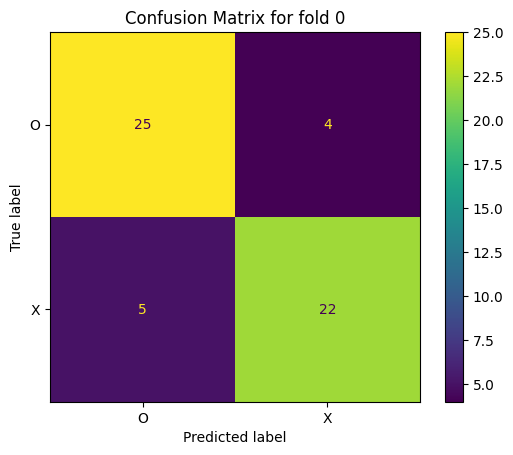

FOLD 1
--------------------------------
Epoch [1/7], Loss: 0.6666
Validation Loss: 0.4620, Accuracy: 85.71%
Epoch [2/7], Loss: 0.5951
Validation Loss: 0.4356, Accuracy: 83.93%
Epoch [3/7], Loss: 0.5536
Validation Loss: 0.4992, Accuracy: 82.14%
Epoch [4/7], Loss: 0.4744
Validation Loss: 0.4576, Accuracy: 83.93%
Epoch [5/7], Loss: 0.4497
Validation Loss: 0.4121, Accuracy: 89.29%
Epoch [6/7], Loss: 0.4322
Validation Loss: 0.4782, Accuracy: 80.36%
Epoch [7/7], Loss: 0.3873
Validation Loss: 0.4303, Accuracy: 87.50%


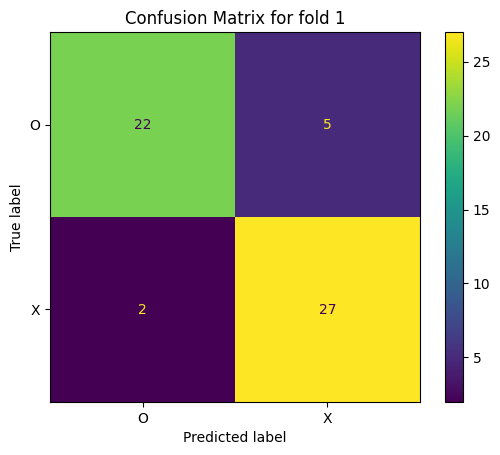

FOLD 2
--------------------------------
Epoch [1/7], Loss: 0.6126
Validation Loss: 0.6508, Accuracy: 64.29%
Epoch [2/7], Loss: 0.5123
Validation Loss: 0.5881, Accuracy: 71.43%
Epoch [3/7], Loss: 0.4894
Validation Loss: 0.5124, Accuracy: 78.57%
Epoch [4/7], Loss: 0.4761
Validation Loss: 0.5611, Accuracy: 75.00%
Epoch [5/7], Loss: 0.4998
Validation Loss: 0.5789, Accuracy: 73.21%
Epoch [6/7], Loss: 0.5386
Validation Loss: 0.5471, Accuracy: 76.79%
Epoch [7/7], Loss: 0.4808
Validation Loss: 0.4970, Accuracy: 80.36%


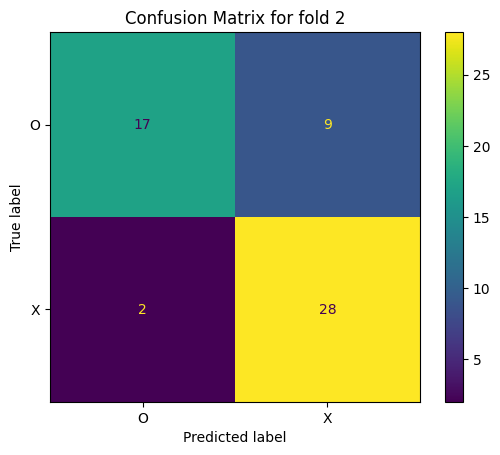

FOLD 3
--------------------------------
Epoch [1/7], Loss: 0.6709
Validation Loss: 0.5457, Accuracy: 75.00%
Epoch [2/7], Loss: 0.5108
Validation Loss: 0.5740, Accuracy: 73.21%
Epoch [3/7], Loss: 0.4603
Validation Loss: 0.5526, Accuracy: 76.79%
Epoch [4/7], Loss: 0.4160
Validation Loss: 0.5271, Accuracy: 78.57%
Epoch [5/7], Loss: 0.3862
Validation Loss: 0.5162, Accuracy: 80.36%
Epoch [6/7], Loss: 0.4177
Validation Loss: 0.5392, Accuracy: 76.79%
Epoch [7/7], Loss: 0.4081
Validation Loss: 0.4926, Accuracy: 82.14%


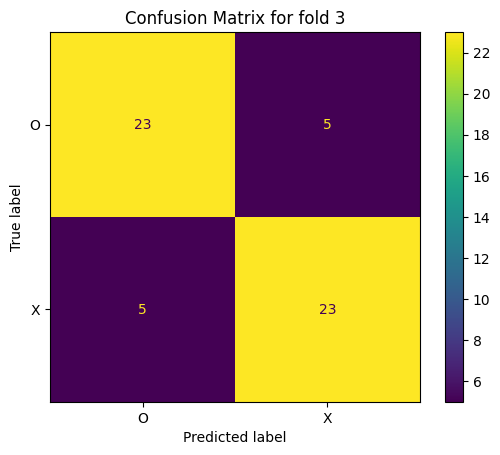

FOLD 4
--------------------------------
Epoch [1/7], Loss: 0.7126
Validation Loss: 0.6709, Accuracy: 53.57%
Epoch [2/7], Loss: 0.5893
Validation Loss: 0.5035, Accuracy: 78.57%
Epoch [3/7], Loss: 0.5205
Validation Loss: 0.4044, Accuracy: 91.07%
Epoch [4/7], Loss: 0.4629
Validation Loss: 0.4451, Accuracy: 85.71%
Epoch [5/7], Loss: 0.4375
Validation Loss: 0.4081, Accuracy: 89.29%
Epoch [6/7], Loss: 0.3888
Validation Loss: 0.4073, Accuracy: 87.50%
Epoch [7/7], Loss: 0.3660
Validation Loss: 0.4043, Accuracy: 91.07%


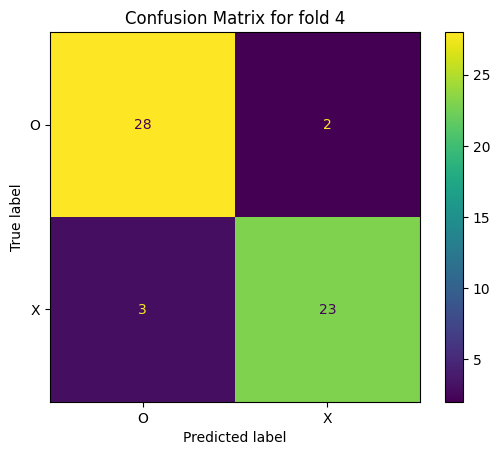

K-Fold Cross Validation Results for 5 Folds
--------------------------------
Fold 0: 83.93%
Fold 1: 87.50%
Fold 2: 80.36%
Fold 3: 82.14%
Fold 4: 91.07%
Average: 85.00%


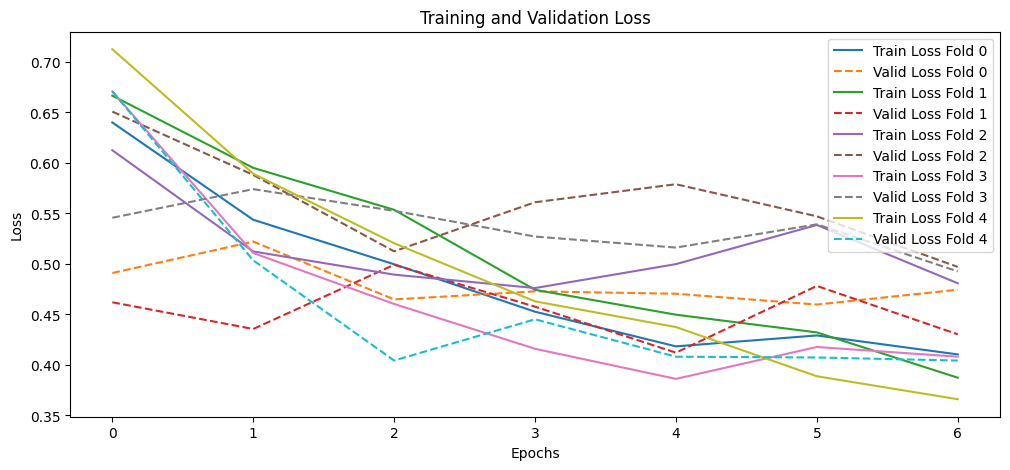

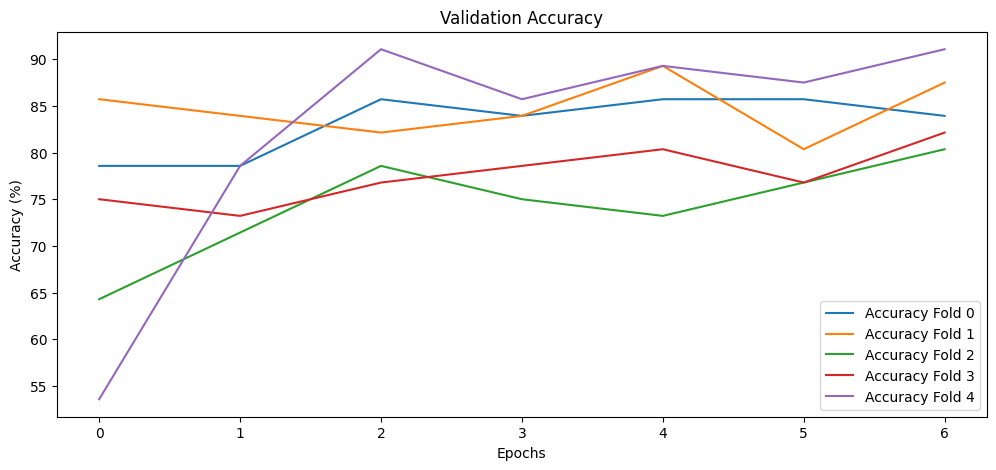

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# K-Fold 설정
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# K-Fold 교차 검증 수행
results = []
train_losses = []
valid_losses = []
accuracies = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # 샘플 인덱스 가져오기
    train_subsampler = Subset(dataset, train_idx)
    test_subsampler = Subset(dataset, test_idx)

    trainloader = DataLoader(train_subsampler, batch_size=20, shuffle=True)
    testloader = DataLoader(test_subsampler, batch_size=20, shuffle=False)

    # 모델 초기화
    model = Classification()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 훈련 루프
    num_epochs = 7
    train_loss_per_epoch = []
    valid_loss_per_epoch = []
    accuracy_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss_per_epoch.append(running_loss/len(trainloader))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')

        # 검증 단계
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss_per_epoch.append(valid_loss/len(testloader))
        accuracy = 100 * correct / total
        accuracy_per_epoch.append(accuracy)
        print(f'Validation Loss: {valid_loss/len(testloader):.4f}, Accuracy: {accuracy:.2f}%')

    train_losses.append(train_loss_per_epoch)
    valid_losses.append(valid_loss_per_epoch)
    accuracies.append(accuracy_per_epoch)

    # 모델 평가
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot()
    plt.title(f'Confusion Matrix for fold {fold}')
    plt.show()

    results.append(accuracy)

# 전체 결과 출력
print(f'K-Fold Cross Validation Results for {k_folds} Folds')
print('--------------------------------')
for i in range(k_folds):
    print(f'Fold {i}: {results[i]:.2f}%')
print(f'Average: {np.mean(results):.2f}%')

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
for fold in range(k_folds):
    plt.plot(train_losses[fold], label=f'Train Loss Fold {fold}')
    plt.plot(valid_losses[fold], label=f'Valid Loss Fold {fold}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.figure(figsize=(12, 5))
for fold in range(k_folds):
    plt.plot(accuracies[fold], label=f'Accuracy Fold {fold}')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


k-fold를 적용하지 않음.
epoch = 10
batch size = 20

Epoch [1/10], Loss: 0.6787
Validation Loss: 0.4884, Accuracy: 82.14%
Epoch [2/10], Loss: 0.4794
Validation Loss: 0.4896, Accuracy: 82.14%
Epoch [3/10], Loss: 0.4662
Validation Loss: 0.4582, Accuracy: 85.71%
Epoch [4/10], Loss: 0.4338
Validation Loss: 0.4262, Accuracy: 89.29%
Epoch [5/10], Loss: 0.4163
Validation Loss: 0.4256, Accuracy: 89.29%
Epoch [6/10], Loss: 0.3906
Validation Loss: 0.4240, Accuracy: 89.29%
Epoch [7/10], Loss: 0.3983
Validation Loss: 0.4038, Accuracy: 91.07%
Epoch [8/10], Loss: 0.3683
Validation Loss: 0.4055, Accuracy: 91.07%
Epoch [9/10], Loss: 0.3777
Validation Loss: 0.3905, Accuracy: 92.86%
Epoch [10/10], Loss: 0.3594
Validation Loss: 0.3773, Accuracy: 94.64%


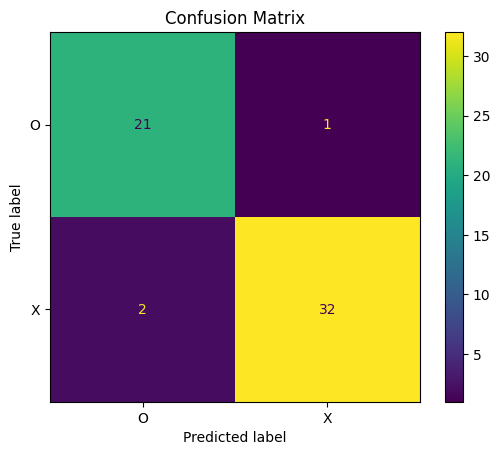

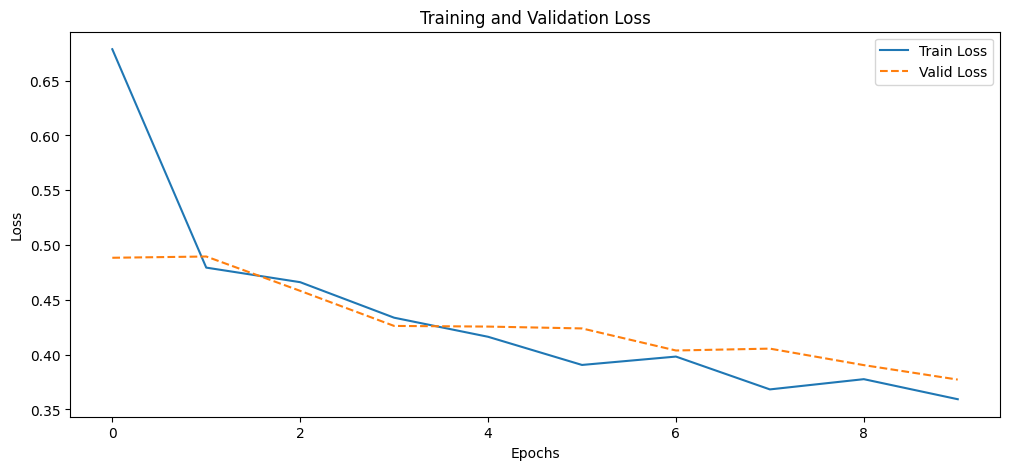

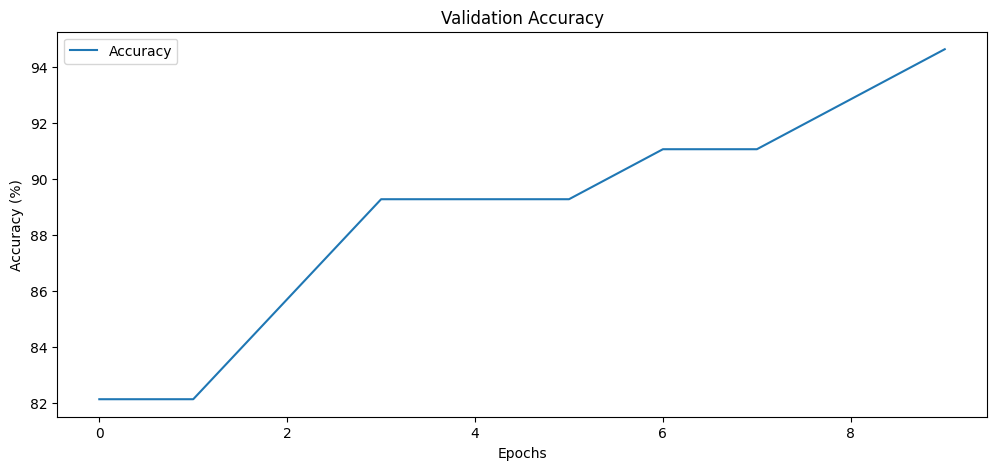

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
model = Classification()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 10
train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

# 모델 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.figure(figsize=(12, 5))
plt.plot(accuracies, label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


위의 코드에서 에폭을 15로 설정 -> x



Epoch [1/15], Loss: 0.6905
Validation Loss: 0.5112, Accuracy: 80.36%
Epoch [2/15], Loss: 0.4790
Validation Loss: 0.4513, Accuracy: 85.71%
Epoch [3/15], Loss: 0.4176
Validation Loss: 0.4000, Accuracy: 91.07%
Epoch [4/15], Loss: 0.3952
Validation Loss: 0.3798, Accuracy: 92.86%
Epoch [5/15], Loss: 0.3818
Validation Loss: 0.3695, Accuracy: 92.86%
Epoch [6/15], Loss: 0.3678
Validation Loss: 0.3583, Accuracy: 94.64%
Epoch [7/15], Loss: 0.3537
Validation Loss: 0.4463, Accuracy: 85.71%
Epoch [8/15], Loss: 0.3723
Validation Loss: 0.3887, Accuracy: 92.86%
Epoch [9/15], Loss: 0.3893
Validation Loss: 0.3873, Accuracy: 92.86%
Epoch [10/15], Loss: 0.3549
Validation Loss: 0.4290, Accuracy: 87.50%
Epoch [11/15], Loss: 0.3518
Validation Loss: 0.4181, Accuracy: 89.29%
Epoch [12/15], Loss: 0.3363
Validation Loss: 0.3633, Accuracy: 94.64%
Epoch [13/15], Loss: 0.3764
Validation Loss: 0.4466, Accuracy: 85.71%
Epoch [14/15], Loss: 0.4707
Validation Loss: 0.5671, Accuracy: 73.21%
Epoch [15/15], Loss: 0.4212
V

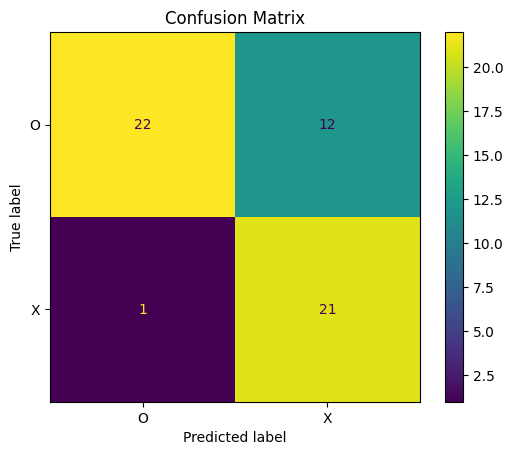

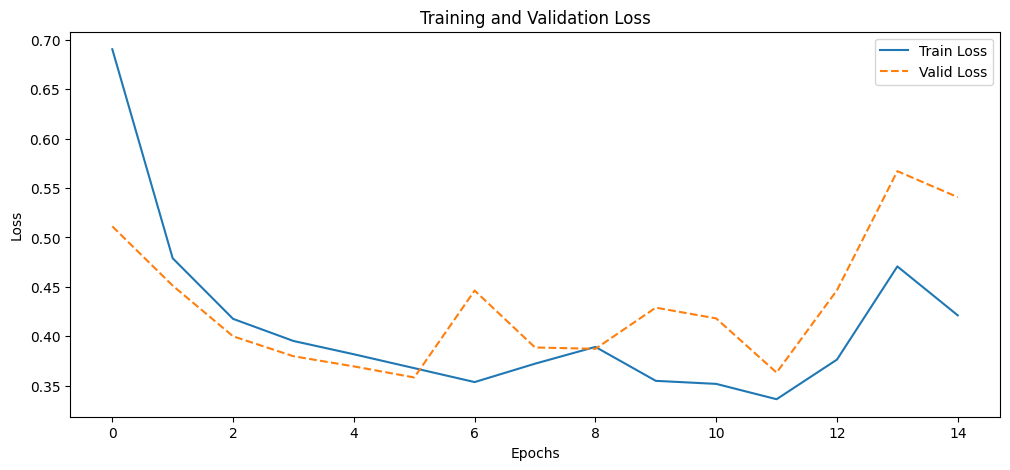

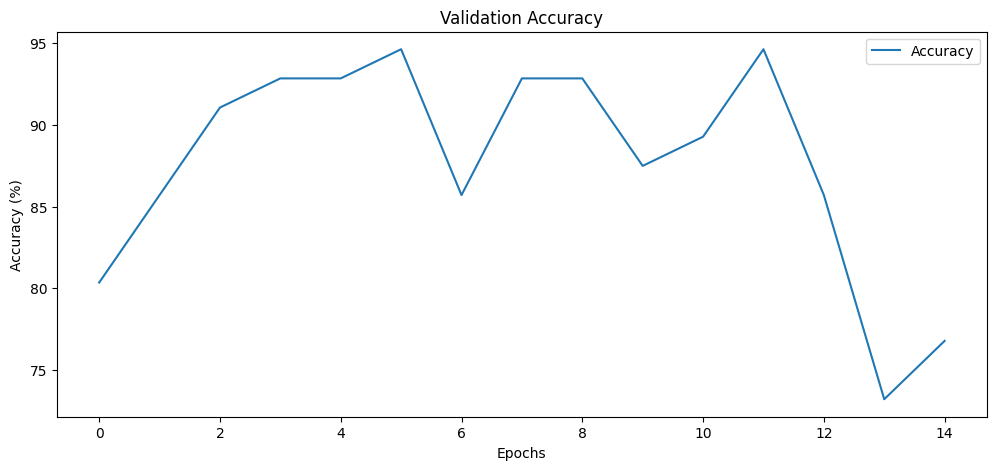

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
model = Classification()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 15
train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

    # 검증 단계
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_losses.append(valid_loss / len(testloader))
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Validation Loss: {valid_loss / len(testloader):.4f}, Accuracy: {accuracy:.2f}%')

# 모델 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.figure(figsize=(12, 5))
plt.plot(accuracies, label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


원-핫 인코딩/
분류 과정 시각화/
val_loss, val_acc

이미지 시각화 추가함

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
model = Classification()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 평가
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    test_images = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            test_images.extend(images.cpu().numpy())

    valid_loss /= len(testloader)
    valid_losses.append(valid_loss)
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix at Epoch {epoch+1}')
    plt.show()

    # 전체 이미지를 시각화
    num_images = len(test_images)
    fig, axes = plt.subplots(num_images // 5 + 1, 5, figsize=(15, num_images // 2))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(test_images, y_true, y_pred, axes):
        img = np.transpose(img, (1, 2, 0))
        img = img * sigma + mean  # Normalize back to original
        img = np.clip(img, 0, 1)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 손실 및 정확도 시각화
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 최종 결과 출력
print("Training complete.")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
model = Classification()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 평가
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    test_images = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            test_images.extend(images.cpu().numpy())

    valid_loss /= len(testloader)
    valid_losses.append(valid_loss)
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix at Epoch {epoch+1}')
    plt.show()

    # 전체 이미지를 시각화
    num_images = len(test_images)
    fig, axes = plt.subplots(num_images // 5 + 1, 5, figsize=(15, num_images // 2))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(test_images, y_true, y_pred, axes):
        img = np.transpose(img, (1, 2, 0))
        img = img * sigma + mean  # Normalize back to original
        img = np.clip(img, 0, 1)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 손실 및 정확도 시각화
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 최종 결과 출력
print("Training complete.")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
model = Classification()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 6
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 평가
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    test_images = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            test_images.extend(images.cpu().numpy())

    valid_loss /= len(testloader)
    valid_losses.append(valid_loss)
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix at Epoch {epoch+1}')
    plt.show()

    # 전체 이미지를 시각화
    num_images = len(test_images)
    fig, axes = plt.subplots(num_images // 5 + 1, 5, figsize=(15, num_images // 2))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(test_images, y_true, y_pred, axes):
        img = np.transpose(img, (1, 2, 0))
        img = img * sigma + mean  # Normalize back to original
        img = np.clip(img, 0, 1)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 손실 및 정확도 시각화
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 최종 결과 출력
print("Training complete.")

torch.save(model.state_dict(), 'CNN_model.pth')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

class LOOCVDataset(Dataset):
    def __init__(self, dataset, leave_out_index):
        self.dataset = dataset
        self.leave_out_index = leave_out_index

    def __len__(self):
        return len(self.dataset) - 1

    def __getitem__(self, idx):
        if idx >= self.leave_out_index:
            idx += 1
        return self.dataset[idx]

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()

# 훈련 및 검증 루프
num_epochs = 7
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
y_true = []
y_pred = []
test_images = []

for i in range(len(dataset)):
    train_dataset = LOOCVDataset(dataset, i)
    val_dataset = torch.utils.data.Subset(dataset, [i])
    trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = Classification()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'LOOCV [{i+1}/{len(dataset)}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 평가
    model.eval()
    with torch.no_grad():
        for images, labels in valloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            test_images.extend(images.cpu().numpy())
            valid_losses.append(loss.item())
            valid_accuracies.append((predicted == labels).sum().item() / labels.size(0) * 100)

# 최종 결과 출력 및 시각화
print(f'Average Training Loss: {np.mean(train_losses):.4f}')
print(f'Average Training Accuracy: {np.mean(train_accuracies):.2f}%')
print(f'Average Validation Loss: {np.mean(valid_losses):.4f}')
print(f'Average Validation Accuracy: {np.mean(valid_accuracies):.2f}%')

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 전체 이미지를 시각화
num_images = len(test_images)
fig, axes = plt.subplots(num_images // 5 + 1, 5, figsize=(15, num_images // 2))
axes = axes.flatten()
for img, true_label, pred_label, ax in zip(test_images, y_true, y_pred, axes):
    img = np.transpose(img, (1, 2, 0))
    img = img * sigma + mean  # Normalize back to original
    img = np.clip(img, 0, 1)
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 손실 및 정확도 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo-', label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('LOOCV iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('LOOCV iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

print("Training complete.")


torch.save(model.state_dict(), 'model_LOOCV.pth')


LOOCV [1/280], Loss: 0.0413, Accuracy: 98.57%
LOOCV [2/280], Loss: 0.1218, Accuracy: 96.77%
LOOCV [3/280], Loss: 0.0825, Accuracy: 98.92%
LOOCV [4/280], Loss: 0.6934, Accuracy: 47.31%
LOOCV [5/280], Loss: 0.0216, Accuracy: 98.92%
LOOCV [6/280], Loss: 0.0708, Accuracy: 98.92%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 전처리
mean = 0.5
sigma = 0.5
trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[mean], std=[sigma])
])
dataset = datasets.ImageFolder(root='./OX_Dataset/Dataset', transform=trans)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 정의
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
model = Classification()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 6
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # 모델 평가
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    test_images = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            test_images.extend(images.cpu().numpy())

    valid_loss /= len(testloader)
    valid_losses.append(valid_loss)
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix at Epoch {epoch+1}')
    plt.show()

    # 전체 이미지를 시각화
    num_images = len(test_images)
    fig, axes = plt.subplots(num_images // 5 + 1, 5, figsize=(15, num_images // 2))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(test_images, y_true, y_pred, axes):
        img = np.transpose(img, (1, 2, 0))
        img = img * sigma + mean  # Normalize back to original
        img = np.clip(img, 0, 1)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 손실 및 정확도 시각화
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 최종 결과 출력
print("Training complete.")

torch.save(model.state_dict(), 'CNN_model.pth')